# (7주차) 10월21일
> Pytorch CNN (MNIST 3,7)

- toc:true
- branch: master
- badges: true
- comments: true
- author: 최규빈
- categories: [Python]

---

### import 

In [1]:
import torch 
from fastai.vision.all import * 

In [2]:
import graphviz

In [3]:
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+ s + ';}')

### data 

`-` download data 

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
path.ls()

(#3) [Path('/home/khy/.fastai/data/mnist_sample/train'),Path('/home/khy/.fastai/data/mnist_sample/valid'),Path('/home/khy/.fastai/data/mnist_sample/labels.csv')]

`-` list 

In [6]:
threes=(path/'train'/'3').ls()
sevens=(path/'train'/'7').ls()

`-` list $\to$ image 

In [7]:
Image.open(threes[4])

`-` image $\to$ tensor 

In [8]:
tensor(Image.open(threes[4]))

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  36, 211, 254, 254,
         241, 144, 144,  35,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

- 여기에서 tensor는 파이토치가 아니라 fastai에서 구현한 함수임 

`-` 여러개의 리스트를 모두 텐서로 바꿔보자. 

In [9]:
seven_tensor = torch.stack([tensor(Image.open(i)) for i in sevens]).float()/255
three_tensor = torch.stack([tensor(Image.open(i)) for i in threes]).float()/255

`-` $X$와 $y$를 만들자. 

In [10]:
seven_tensor.shape, three_tensor.shape

(torch.Size([6265, 28, 28]), torch.Size([6131, 28, 28]))

In [11]:
y=torch.tensor([0.0]*6265+ [1.0]*6131).reshape(12396,1)

In [12]:
X=torch.vstack([seven_tensor,three_tensor]).reshape(12396,-1)

In [13]:
X.shape, y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

### 기존의 MLP 모형 

${\bf X} \to {\bf WX+b} \to f({\bf WX+b}) \to \dots \to {\bf y}$
- ${\bf X}=12396 \times 784$ matrix 
- ${\bf y}=12396 \times 1$ (col) vector

`-` 교재의 모형 

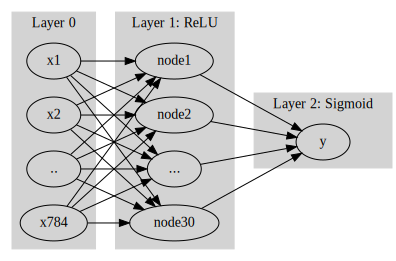

In [14]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node30" -> "y"
    label = "Layer 2: Sigmoid"
}
''')

`-` 왜 28$\times$28 이미지를 펼쳐서 784개의 벡터로 만든 다음에 모형을 돌려야 하는가? 

`-` 기존에 개발된 모형이 회귀분석 기반으로 되어있어서 결국 **회귀분석 틀에 짜 맞추어서 이미지자료를 분석하는 느낌** 

`-` observation의 차원은 $784$가 아니라 $1\times (28\times 28)$이 되어야 맞다. 
> 예제는 흑백이라서 $1\times(28\times28)$로 나타나고, 컬러인 경우에는 $3\times(28\times28)$

In [15]:
X.shape

torch.Size([12396, 784])

In [18]:
X=X.reshape(12396,1,28,28) 

In [17]:
X.shape

torch.Size([12396, 1, 28, 28])

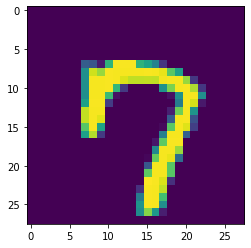

In [21]:
plt.imshow(X[776][0])   #[0]꼭 넣어주기(흑백이미지여서?)

### 선형변환 대신에 2d convolution with windowsize=5

* window size=5 이면 window는 5X5

In [1]:
c1=torch.nn.Conv2d(1,16,5) # 입력채널=1 (흑백이므로), 출력채널=16, 윈도우크기5 

NameError: name 'torch' is not defined

In [25]:
X.shape, c1(X).shape

(torch.Size([12396, 1, 28, 28]), torch.Size([12396, 16, 24, 24]))

> **X.shape는 28인데 왜 c1(X).shape는 24인가요?**  
윈도우 사이즈가 5씩 움직이다 보면, 첫 시작 윈도우는 1-5, 마지막 윈도우는 24-28이 된다.  
$\to$ 약간 겹치는 부분이 생기다 보니 숫자가 달라진 것이다!  
$\to$ $28\times 28$행렬에서 $24\times 24$로 차원이 변함

> **1에서 16으로 변한 것은 뭐지?**  
  1개 이미지를 16개로 나눈 것 ! (뻥튀기 했다)

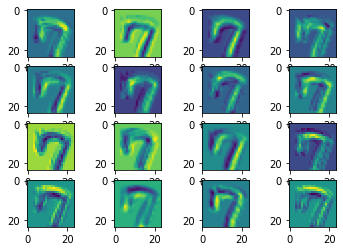

In [24]:
fig, axs = plt.subplots(4,4) 
k=0 
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(c1(X)[776][k].data) 
        k=k+1

> 같은 777번째 이미지(0포함 776번째) 불러오고,  
  1개였던 이미지가 16개가 되니까 k는 1에서 16까지 변함.  
  .data는 선형 변환된 값이 출력되어 나오는데 미분되어 나오니까 붙여줘야 함.

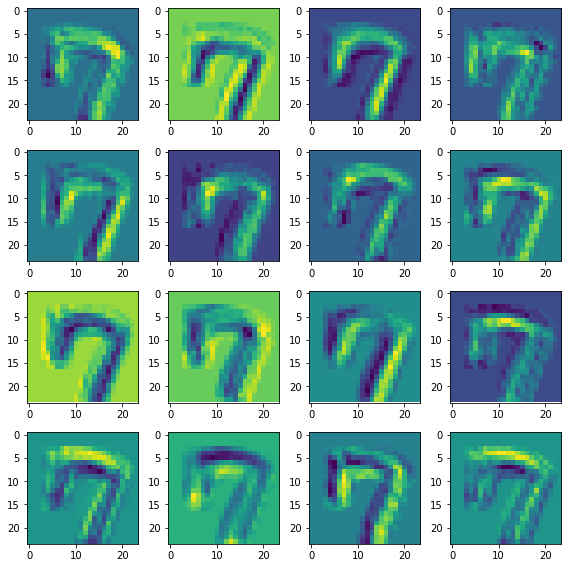

In [26]:
#사이즈 키우기
fig.set_figheight(8)
fig.set_figwidth(8)
fig.tight_layout()
fig

### ReLU() 대신 MaxPool2d + ReLU

#### MaxPool2d

In [37]:
m1=torch.nn.MaxPool2d(2)  #여기서 2를 넣어서 24->12로 바뀜

In [28]:
X.shape,c1(X).shape,m1(c1(X)).shape

(torch.Size([12396, 1, 28, 28]),
 torch.Size([12396, 16, 24, 24]),
 torch.Size([12396, 16, 12, 12]))

> 12,12는 왜 등장했는지 확인해보자.

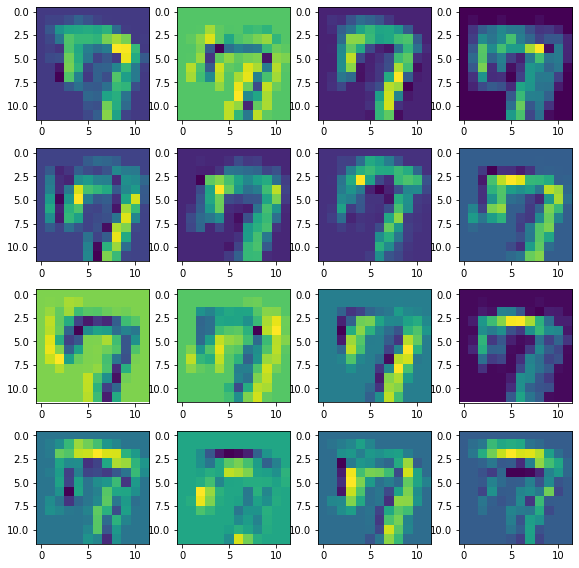

In [29]:
fig, axs = plt.subplots(4,4) 
k=0 
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(m1(c1(X))[776][k].data) 
        k=k+1
fig.set_figheight(8)
fig.set_figwidth(8)
fig.tight_layout()    

> **비교**  
  화질이 좀 안 좋아진 것 같다  
  MaxPooling의 역할은 데이터의 단순화$\to$저화질로 변함  
  다른 역할은 다음에 설명 추가!

#### ReLU 

In [30]:
a1=torch.nn.ReLU()

In [31]:
X.shape,c1(X).shape, m1(c1(X)).shape, a1(m1(c1(X))).shape

(torch.Size([12396, 1, 28, 28]),
 torch.Size([12396, 16, 24, 24]),
 torch.Size([12396, 16, 12, 12]),
 torch.Size([12396, 16, 12, 12]))

> ReLU를 거쳐도 숫자에서 바뀌는 것은 없음  
  하지만 비선형 과정을 거치기 때문에 약간 달리지는 것이 있음!

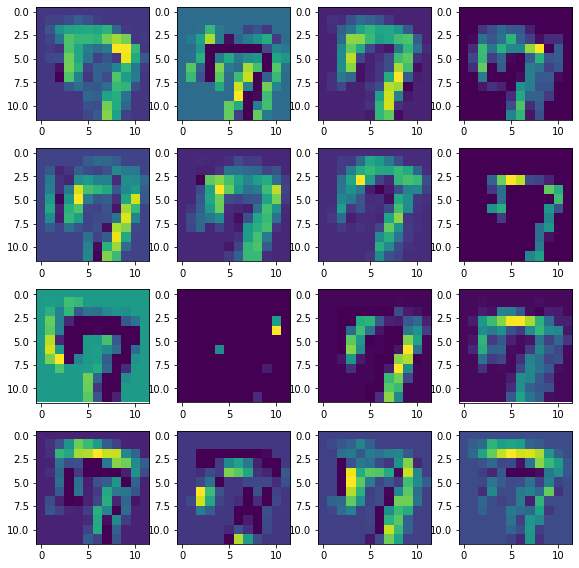

In [32]:
fig, axs = plt.subplots(4,4) 
k=0 
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(a1(m1(c1(X)))[776][k].data) 
        k=k+1
fig.set_figheight(8)
fig.set_figwidth(8)
fig.tight_layout()    

> 몇 개의 이미지가 잘린 모습, 배경 색이 변함(초록에서 남색으로)  

-   ReLU는 0보다 크면 살리고, 0보다 작으면 날리는 방식으로 작동함

확인해보기!

In [33]:
torch.manual_seed(1)
_A= torch.randn((3,3))
_A

tensor([[ 0.6614,  0.2669,  0.0617],
        [ 0.6213, -0.4519, -0.1661],
        [-1.5228,  0.3817, -1.0276]])

In [34]:
a1(_A)

tensor([[0.6614, 0.2669, 0.0617],
        [0.6213, 0.0000, 0.0000],
        [0.0000, 0.3817, 0.0000]])

### 여기에서 그냥 시그모이드에 태우자. 

`-` 현재상황 

In [35]:
a1(m1(c1(X))).shape

torch.Size([12396, 16, 12, 12])

`-` 펼치자
> 결국 y는 0,1의 값을 가지기 때문에 우리는 기존 신경망과 비슷하게 만들어야(펼쳐야) 함

In [36]:
a1(m1(c1(X))).reshape(12396,-1).shape

torch.Size([12396, 2304])

In [38]:
16*12*12

2304

`-` 2304의 디멘젼을 1로 만들자. 
> 숨겨진 layer 없이 바로! 선형변환을 통해 2304의 디멘젼을 1로!

In [39]:
l1=torch.nn.Linear(in_features=2304,out_features=1) 

In [40]:
l1(a1(m1(c1(X))).reshape(12396,-1))

tensor([[-0.0645],
        [-0.0081],
        [-0.0085],
        ...,
        [-0.0154],
        [-0.0199],
        [-0.1047]], grad_fn=<AddmmBackward>)

`-` 시그모이드를 걸자. 

In [41]:
a2=torch.nn.Sigmoid() 
a2(l1(a1(m1(c1(X))).reshape(12396,-1)))

tensor([[0.4839],
        [0.4980],
        [0.4979],
        ...,
        [0.4961],
        [0.4950],
        [0.4738]], grad_fn=<SigmoidBackward>)

### networks 설계 

In [42]:
net = nn.Sequential(
    c1, # 컨볼루션(선형)
    m1, # 맥스풀링(비선형) -- 효과? 이미지를 계층적으로 파악할 수 있게함 
    a1, # 렐루(비선형) 
    
    a1(m1(c1(X))).reshape(12396,-1), ## 이걸 구현해야하는데?? 
    
    l1) 
## 마지막의 a2(sigmoid)는 생략한다. torch.nn..BCEWithLogitsLoss()에 내장되어 있을것이므로 

TypeError: torch.FloatTensor is not a Module subclass

In [43]:
net = nn.Sequential(
    c1, # 컨볼루션(선형)
    m1, # 맥스풀링(비선형) -- 효과? 이미지를 계층적으로 파악할 수 있게함 
    a1, # 렐루(비선형) 
    
#    a1(m1(c1(X))).reshape(12396,-1), ## 이걸 구현해야하는데?? 
    
    l1) 
## 마지막의 a2는 생략한다. torch.nn..BCEWithLogitsLoss()에 내장되어 있을것이므로 


`-` 결국 주석처리한 부분을 구현해야함. 

`-` `c1`,`m1`,`a1`,`l1`의 공통점 

- 무언가를 상속받는 클래스에서 생성된 인스턴스이다. 
- forward메소드가 있다. 

`-` custom layer를 만드는 방법 
- torch.nn.Module(=슈퍼클래스)을 상속받아서 클래스를 하나 만든다. 
- forward 메소드를 정의한다. (다음레이어로 리턴할 값)

In [44]:
class Flatten(torch.nn.Module):
    def forward(self,x): 
        return x.reshape(12396,-1)

In [45]:
flatten=Flatten()

In [46]:
flatten(a1(m1(c1(X)))).shape

torch.Size([12396, 2304])

`-` 잘 구현이 된 것 같다. 네트워크 설정 완료! 

In [47]:
net = nn.Sequential(
    c1, # 컨볼루션(선형)
    m1, # 맥스풀링(비선형) -- 효과? 이미지를 계층적으로 파악할 수 있게함 
    a1, # 렐루(비선형) 
    flatten,#    a1(m1(c1(X))).reshape(12396,-1), ## 이걸 구현해야하는데?? 
    l1) 
## 마지막의 a2는 생략한다. torch.nn..BCEWithLogitsLoss()에 내장되어 있을것이므로 

`-` 손실함수와 옵티마이저 정의 

In [48]:
loss_fn=torch.nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(net.parameters())

`-` step1~4

In [49]:
for epoc in range(200): 
    ## 1 
    yhat=net(X)
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step()
    net.zero_grad()

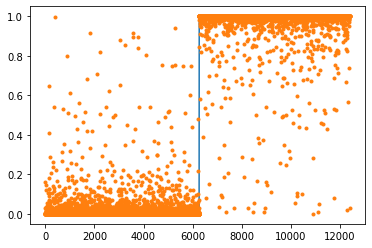

In [51]:
plt.plot(y)
plt.plot(a2(yhat.data),'.')  #마지막 시그모이드 취해준다

In [52]:
ypred=a2(yhat.data)>0.5 

In [53]:
sum(ypred==y)/12396

tensor([0.9927])

`-` 좀 더 성능이 좋아졌다. (이미 좋았는데 약간 더 좋아짐) 

### 숙제 

`-` torch.nn.MaxPool2d(2) 대신 torch.nn.MaxPool2d(3) 을 사용하여 모형을 학습해보고 결과비교

In [62]:
m2=torch.nn.MaxPool2d(3)  #3를 넣어서 24->8로 바뀜

In [63]:
X.shape,c1(X).shape, m2(c1(X)).shape, a1(m2(c1(X))).shape

(torch.Size([12396, 1, 28, 28]),
 torch.Size([12396, 16, 24, 24]),
 torch.Size([12396, 16, 8, 8]),
 torch.Size([12396, 16, 8, 8]))

In [64]:
flatten(a1(m2(c1(X)))).shape

torch.Size([12396, 1024])

In [65]:
16*8*8

1024

In [74]:
l2=torch.nn.Linear(in_features=1024,out_features=1) 

In [75]:
net = nn.Sequential(
    c1, # 컨볼루션(선형)
    m2, # 맥스풀링(비선형) -- 효과? 이미지를 계층적으로 파악할 수 있게함 
    a1, # 렐루(비선형) 
    flatten, 
    l2) 
## 마지막의 a2는 생략한다. torch.nn..BCEWithLogitsLoss()에 내장되어 있을것이므로 

In [76]:
loss_fn=torch.nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(net.parameters())

In [77]:
for epoc in range(200): 
    ## 1 
    yhat=net(X)
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step()
    net.zero_grad()

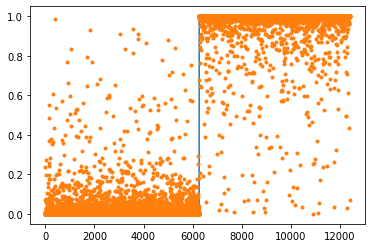

In [78]:
plt.plot(y)
plt.plot(a2(yhat.data),'.')  #마지막 시그모이드 취해준다

In [79]:
ypred=a2(yhat.data)>0.5 

In [80]:
sum(ypred==y)/12396

tensor([0.9894])

- 2로 했을 때 보다 성능이 약간 안 좋아졌다. 그림으로는 큰 차이 없어보임..